# **Bag of Visual Words**

---

#### Team 3
* Daniel Pardo
* Francisco de Paula de Urmeneta
* Pablo Vega
---


In [1]:
#To read directly from Drive in Google Colab use:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#Path to our folder in Drive
%cd /content/drive/MyDrive/Colab Notebooks/C3

/content/drive/MyDrive/Colab Notebooks/C3


### Import dependencies

In [3]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import seaborn as sns
import matplotlib.pyplot as plt
!pip install optuna
import optuna
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.5 MB/s eta 0:00:00


### Load data

Let us first read the train and test files

In [4]:
folder = 'MIT_split'
train_images_filenames = pickle.load(open('./'+folder+'/train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('./'+folder+'/test_images_filenames.dat','rb'))
train_images_filenames = ['.' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['.' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('./'+folder+'/train_labels.dat','rb'))
test_labels = pickle.load(open('./'+folder+'/test_labels.dat','rb'))

print("Total images:", len(train_images_filenames)+len(test_images_filenames))
print(f"Split percentage: {round(len(train_images_filenames)/(len(train_images_filenames)+len(test_images_filenames))*100)}%-{100-round(len(train_images_filenames)/(len(train_images_filenames)+len(test_images_filenames))*100)}% Train-Test")
print("Number of training images:", len(train_images_filenames) ,"labels:", len(train_labels))
print("Number of testing images:", len(test_images_filenames) ,"labels:", len(test_labels))


Total images: 2688
Split percentage: 70%-30% Train-Test
Number of training images: 1881 labels: 1881
Number of testing images: 807 labels: 807


The dataset has a total of 2688 images and is provided divided into traning set and test set with 70% and 30% of the data in each case.

Next we create a function to see the distributions of the classes in each subset

In [ ]:
def show_distributions(train_labels, test_labels):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    sns.countplot(x=train_labels, palette="Set2", ax=axes[0])
    axes[0].bar_label(axes[0].containers[0])
    axes[0].set_xlabel("Labels")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Class distribution - Training dataset")

    sns.countplot(x=test_labels, palette="Set2", ax=axes[1])
    axes[1].bar_label(axes[1].containers[0])
    axes[1].set_xlabel("Labels")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Class distribution - Test dataset")

    for ax in axes:
        total = sum(p.get_height() for p in ax.patches)
        for p in ax.patches:
            percentage = f"{p.get_height() / total * 100:.1f}%"
            x = p.get_x() + p.get_width() / 2
            y = p.get_height() * 0.95
            ax.annotate(percentage, (x, y), ha='center', va='center')
    plt.show()

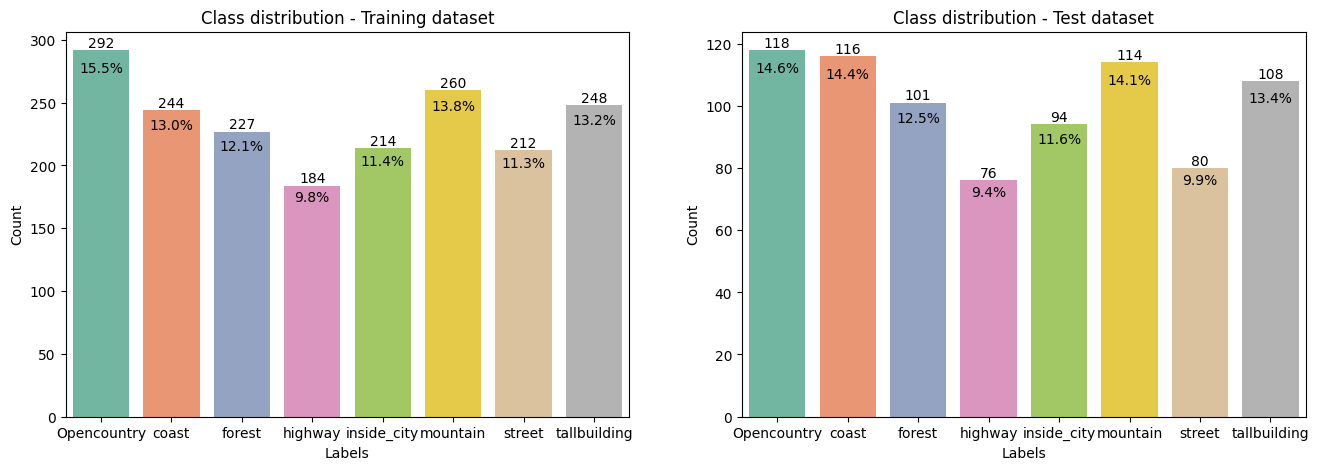

In [ ]:
show_distributions(train_labels, test_labels)

We can see that there are 8 different classes of images depending on the type of content and that the distribution between the training and test set provided is quite similar.

Below we show some examples of the data sets to see the different types of images and their visual characteristics.

In [ ]:
def show_dataset(labels, images_filenames, n_samples):
    classes = np.unique(labels)
    n_classes = len(classes)
    fig, axes = plt.subplots(n_samples, n_classes, figsize=(16, int(n_samples*1.75)))
    for col, label in enumerate(classes):
        indices = np.flatnonzero((np.array(labels) == label))
        indices_selected = np.random.choice(indices, n_samples, replace = False)

        for row, image in enumerate(indices_selected):
            axes[row][col].imshow(cv2.cvtColor(cv2.imread(images_filenames[image]),cv2.COLOR_BGR2RGB), aspect='auto')
            axes[row][col].axis('off')

    #add title
    for row, ax in enumerate(axes[0]):
        ax.set_title(f'{classes[row]}', fontsize=14)

    plt.show()

First for the training set

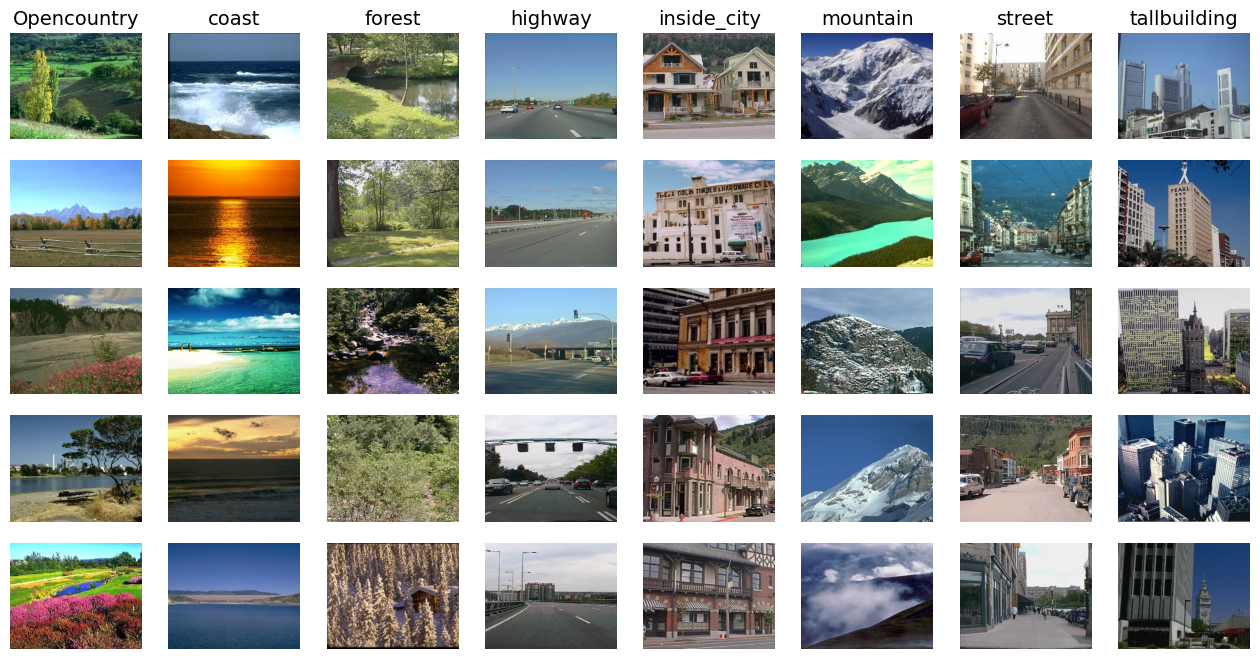

In [ ]:
show_dataset(train_labels, train_images_filenames, 5)

And then the test set

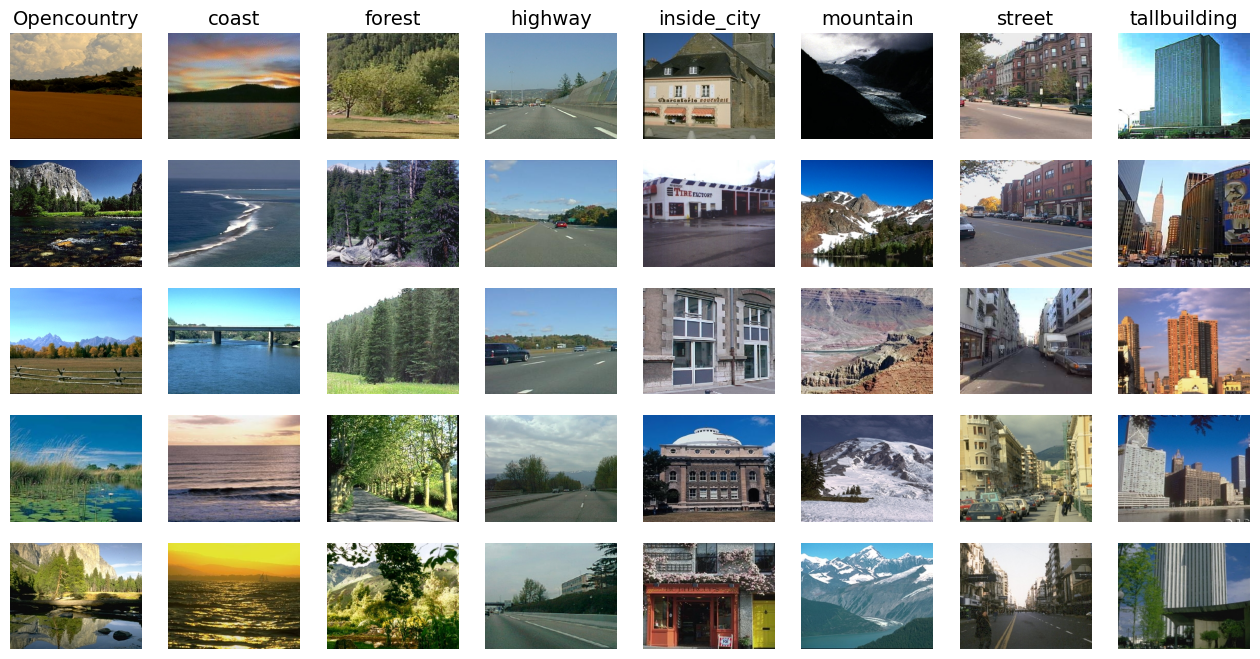

In [ ]:
show_dataset(test_labels, test_images_filenames, 5)

We observe that the two sets have similar images depending on the category, so no bias is observed initially. Some categories are more similar to each other than to the rest, which is likely to pose an added difficulty for the algorithms.

### Local features

There are different algorithms to extract local features. In this section some of the most notable ones will be explored:
* SIFT
* KAZE
* AKAZE
* BRISK
* ORB

In [5]:
def create_descriptors():
    sift = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)
    kaze = cv2.KAZE_create(extended=False, upright=False, threshold=0.0001, nOctaves=4, nOctaveLayers=4)
    akaze = cv2.AKAZE_create(descriptor_type=cv2.AKAZE_DESCRIPTOR_MLDB, descriptor_size=0, descriptor_channels=3, threshold=0.0001, nOctaves=4, nOctaveLayers=4, diffusivity=cv2.KAZE_DIFF_PM_G2)
    brisk = cv2.BRISK_create(thresh=20, octaves=3, patternScale=1.0)
    orb = cv2.ORB_create(nfeatures=500, scaleFactor=1.2, nlevels=8, edgeThreshold=31, firstLevel=0, WTA_K=2, scoreType=cv2.ORB_HARRIS_SCORE, patchSize=31, fastThreshold=20)
    return [sift, kaze, akaze, brisk, orb]

def extract_descriptors(image, descriptor):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    keypoints, descriptor = descriptor.detectAndCompute(image, None)
    return keypoints, descriptor

def show_keypoints(images_filenames, n_samples):
    descriptor_list = create_descriptors()
    images = np.random.choice(train_images_filenames, n_samples, replace = False)

    kp_list = []
    for image in images:
        img = cv2.imread(image)
        kp_image = []
        for method in descriptor_list:
            kp, _ = extract_descriptors(img, method)
            kp_image.append(kp)
        kp_list.append(kp_image)

    fig, axes = plt.subplots(n_samples, len(descriptor_list)+1, figsize=(16, int(n_samples*2.5)))

    for i in range(n_samples):
        for method in range(len(descriptor_list)):
            axes[i][method].imshow(cv2.cvtColor(cv2.drawKeypoints(cv2.imread(images[i]), kp_list[i][method], None), cv2.COLOR_BGR2RGB), aspect='auto')
            axes[i][method].set_title(f'{descriptor_list[method].__class__.__name__}: {len(kp_list[i][method])} keypoints')
            axes[i][method].axis('off')
        axes[i][-1].imshow(cv2.cvtColor(cv2.imread(images[i]),cv2.COLOR_BGR2RGB), aspect='auto')
        axes[i][-1].set_title(f'Original')
        axes[i][-1].axis('off')
    plt.show()


Below are the keypoints detected by the different methods in various images. At first glance we can see the differences between the algorithms, for example in general BRISK detects a greater number of keypoints while AKAZE less.

It should be said that the number of keypoints and descriptors depend on the parameters used and that, in this section, a study is not carried out to obtain the best possible parameters but rather a quick and general comparison.

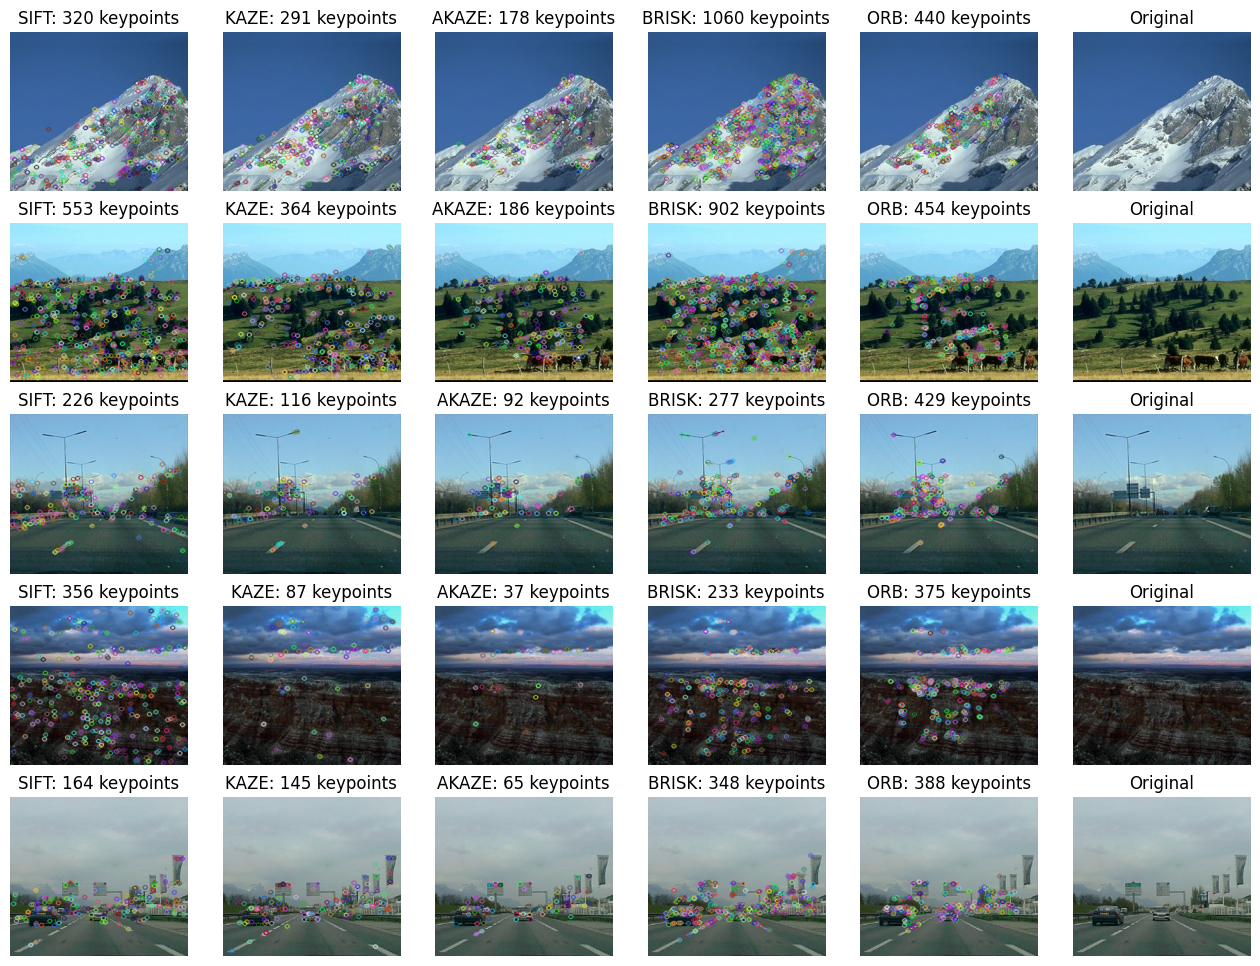

In [ ]:
show_keypoints(train_images_filenames, 5)

One of the requirements of the project is to use cross-validation at all times, and to increase the size of available data, it was decided to join the datasets and evaluate the best model with the cross-validation method, dispensing with a test set.

In [6]:
images_filenames = train_images_filenames + test_images_filenames
labels = train_labels + test_labels

images_labels_list = list(zip(images_filenames, labels))
random.shuffle(images_labels_list)
images_filenames, labels = zip(*images_labels_list)

images_filenames = np.array(images_filenames)
labels = np.array(labels)

Next we make sure that the process has been carried out correctly and we observe the distribution of the image classes again.

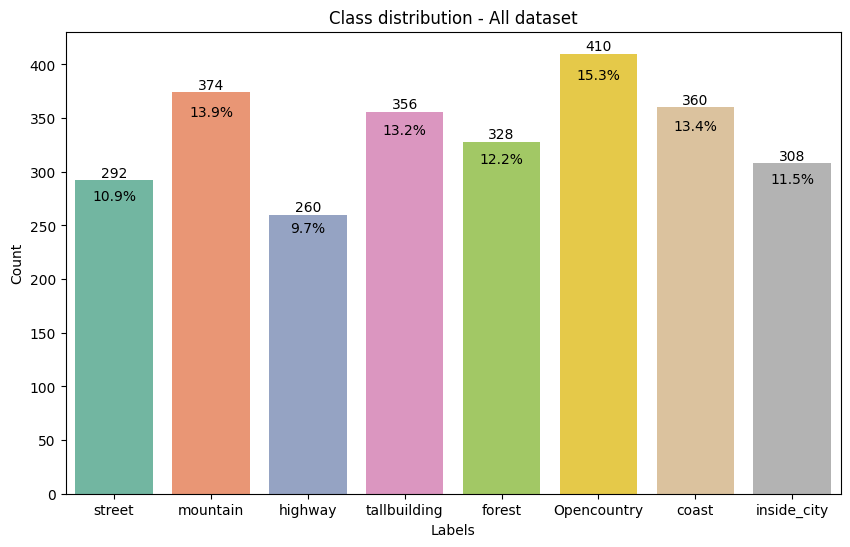

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6))

sns.countplot(x=labels, palette="Set2", ax=axes)
axes.bar_label(axes.containers[0])
axes.set_xlabel("Labels")
axes.set_ylabel("Count")
axes.set_title("Class distribution - All dataset")

total = sum(p.get_height() for p in axes.patches)
for p in axes.patches:
    percentage = f"{p.get_height() / total * 100:.1f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() * 0.95
    axes.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

Next we can apply the general algorithm with the following steps:
* Obtain keypoints and descriptors of all the images of the dataset with any of the local feature extraction algorithms mentioned.
* The evaluation of the model will be done using the cross-validation method, so the dataset is divided in groups. To do this we can use the StratifiedKFold function and set the number of folds to 5.
* In each iteration, the desciptors of the train set images are used to train a clustering algorithm and create a codebook, in this case of 128 clusters.
* Next, we use the algorithm's (codebook) predict function to generate a global descriptor (histogram) of the visual words. This must be done for both the descriptors of the images of the train set and those of the test set.
* With the global descriptors of the train images, a classification algorithm is trained. In this case, KNN with number of neighbors = 3 and Euclidean distance.
* Finally, with trained classifier, we predict the labels of the global descriptors of the test images.
* We measure the performance of the model from this prediction, mainly we will focus on the accurayc metric.

When using the cross-validation method, these steps will be performed 5 times and the final accuracy will be the average accuracy of each of the models.

In [7]:
def create_BoVW(train, test, n_clusters, random_state = None):

    codebook = MiniBatchKMeans(n_clusters=n_clusters, verbose=False, batch_size=n_clusters * 20, compute_labels=False, reassignment_ratio=10**-4, random_state=random_state, n_init=10)
    codebook.fit(np.vstack(train))

    visual_words=np.zeros((len(train),n_clusters),dtype=np.float32)
    for i in range(len(train)):
        words=codebook.predict(train[i])
        visual_words[i,:]=np.bincount(words,minlength=n_clusters)

    visual_words_test=np.zeros((len(test),n_clusters),dtype=np.float32)
    for i in range(len(test)):
        words=codebook.predict(test[i])
        visual_words_test[i,:]=np.bincount(words,minlength=n_clusters)

    return visual_words, visual_words_test

def compute_descriptors(image_filenames, descriptor_methods):
    kp_list = []
    descriptor_list = []
    for method in descriptor_methods:
        kp_image = []
        descriptor_image = []
        for image in images_filenames:
            img = cv2.imread(image)
            kp, desc = extract_descriptors(img, method)
            kp_image.append(kp)
            descriptor_image.append(desc)
        kp_list.append(kp_image)
        descriptor_list.append(descriptor_image)
    return kp_list, descriptor_list

In this cell is the main loop where the explained steps are processed, in this case for more than one local feature extraction method.

In [ ]:
descriptor_methods = create_descriptors()
kp_list, descriptor_list = compute_descriptors(images_filenames, descriptor_methods)

n_clusters = 128
n_folds = 5
random_state = 42

kf = StratifiedKFold(n_splits=n_folds, random_state = random_state, shuffle=True)

accuracy_result = []
f1_result = []

for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
    accuracy_method = []
    f1_method = []
    for method in range(len(descriptor_methods)):
        #train and test data for this fold
        train_kp, test_kp = np.array(kp_list[method], dtype=object)[train_idx], np.array(kp_list[method], dtype=object)[test_idx]
        train_descriptor, test_descriptor = np.array(descriptor_list[method], dtype=object)[train_idx], np.array(descriptor_list[method], dtype=object)[test_idx]
        train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

        visual_words, visual_words_test = create_BoVW(train_descriptor, test_descriptor, n_clusters, random_state)

        knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knn.fit(visual_words, train_labels)

        accuracy_method.append(accuracy_score(test_labels, knn.predict(visual_words_test))*100)
        f1_method.append(f1_score(test_labels, knn.predict(visual_words_test), average='macro')*100)

    accuracy_result.append(accuracy_method)
    f1_result.append(f1_method)

We calculate the average of the scores obtained and show them for each of the models

In [ ]:
accuracy_result = np.array(accuracy_result)
f1_result = np.array(f1_result)

method_names = []
data = []
data.append(np.mean(accuracy_result, axis=0))
data.append(np.mean(f1_result, axis=0))

for method in descriptor_methods:
    method_names.append(method.__class__.__name__)

df = pd.DataFrame(data, columns=method_names, index=['Accuracy', 'F1-score'])
df

SIFT       KAZE      AKAZE      BRISK        ORB
Accuracy  57.625248  57.217157  47.247686  48.958623  31.919032
F1-score  57.660419  57.182634  46.836921  48.947031  30.869595

With the cross-validation method, different score values are obtained for each model of each iteration and the final result is averaged, so it may be interesting to show the diffent values in a boxplot to observe the dispersion of the scores.

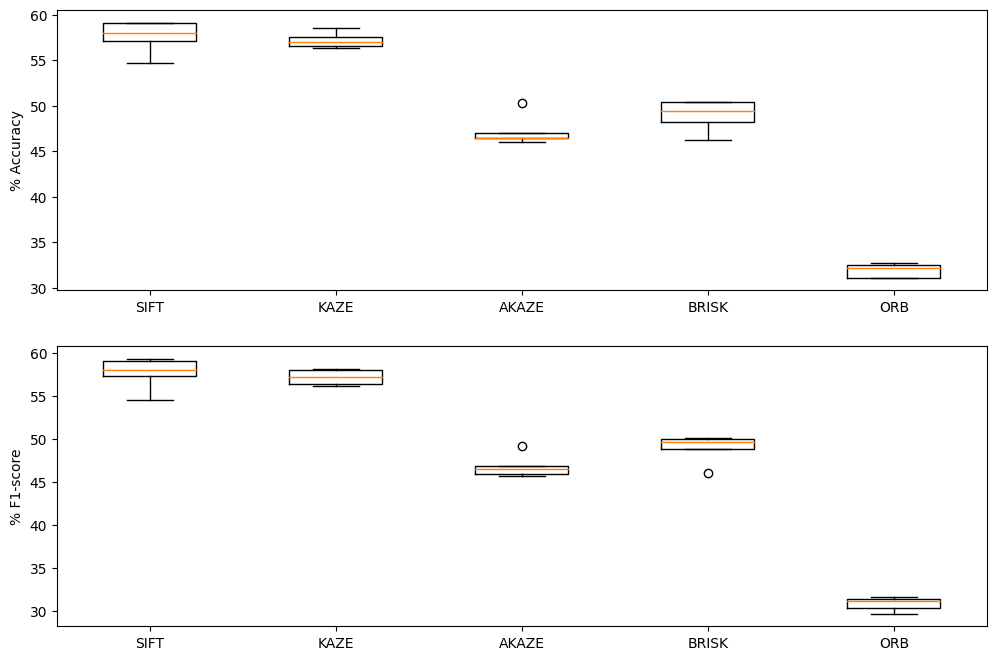

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=( int(len(method_names)*2.5),8))

axes[0].set_ylabel("% Accuracy")
axes[0].boxplot(accuracy_result, labels = method_names)

axes[1].set_ylabel("% F1-score")
axes[1].boxplot(f1_result, labels = method_names)

plt.show()

For example, we observe that in the case of SIFT in one of the iterations the model has obtained significantly lower performance than the rest. With AKAZE and BRISK we also observe these models with a performance that is far from average. In the case of KAZE and ORB the results are more robust, although in the latter case with very low performance compared to the rest of the algorithms.

Next, to analyze the impact of the number of characteristics on the performance of the model, the KAZE algorithm will be used since it has been shown to have good performance, slightly lower than SIFT on average but more robust in terms of the dispersion of the scores.

We create different configurations of algorithm parameters:

In [ ]:
def kaze_configuration():
    kaze1 = cv2.KAZE_create(extended=False, upright=False, threshold=0.0001, nOctaves=3, nOctaveLayers=4)
    kaze2 = cv2.KAZE_create(extended=False, upright=False, threshold=0.0001, nOctaves=4, nOctaveLayers=4)
    kaze3 = cv2.KAZE_create(extended=False, upright=False, threshold=0.00001, nOctaves=4, nOctaveLayers=4)
    kaze4 = cv2.KAZE_create(extended=False, upright=False, threshold=0.00001, nOctaves=5, nOctaveLayers=4)
    kaze5 = cv2.KAZE_create(extended=False, upright=False, threshold=0.00001, nOctaves=6, nOctaveLayers=4)

    return [kaze1, kaze2, kaze3, kaze4, kaze5]

And we apply the steps described again

In [ ]:
descriptor_methods = kaze_configuration()
kp_list, descriptor_list = compute_descriptors(images_filenames, descriptor_methods)

n_clusters = 128
n_folds = 5
random_state = 42

kf = StratifiedKFold(n_splits=n_folds, random_state = random_state, shuffle=True)

accuracy_result = []

for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
    accuracy_method = []
    for method in range(len(descriptor_methods)):
        #train and test data for this fold
        train_kp, test_kp = np.array(kp_list[method], dtype=object)[train_idx], np.array(kp_list[method], dtype=object)[test_idx]
        train_descriptor, test_descriptor = np.array(descriptor_list[method], dtype=object)[train_idx], np.array(descriptor_list[method], dtype=object)[test_idx]
        train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

        visual_words, visual_words_test = create_BoVW(train_descriptor, test_descriptor, n_clusters, random_state)

        knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knn.fit(visual_words, train_labels)

        accuracy_method.append(accuracy_score(test_labels, knn.predict(visual_words_test))*100)

    accuracy_result.append(accuracy_method)


From now on, we will only focus on observing the accuracy score results

In [ ]:
accuracy_result = np.array(accuracy_result)

method_n_descriptors = []

for i in descriptor_list:
    method_n_descriptors.append(str(round(sum(len(j) for j in i)/len(i)))+ ' Features')

df = pd.DataFrame([np.mean(accuracy_result, axis=0)], columns=method_n_descriptors, index=['Accuracy'])
df

834 Features  848 Features  1223 Features  1225 Features  \
Accuracy     57.403515     57.106187      59.151627      59.933612   

          1225 Features  
Accuracy      59.933612

The average features extracted by the algorithm per image have been calculated. Of the five parameter configurations, in general two groups are obtained, two configurations around 850 characteristics and 3 configurations around 1225. In this sense, it is observed that the models that extract a greater number of descriptors perform better and get a higher score. Furthermore, observing the boxplots we observe that there is a bias towards high accuracy values, so in one iteration a model has obtained this highest accuracy value.

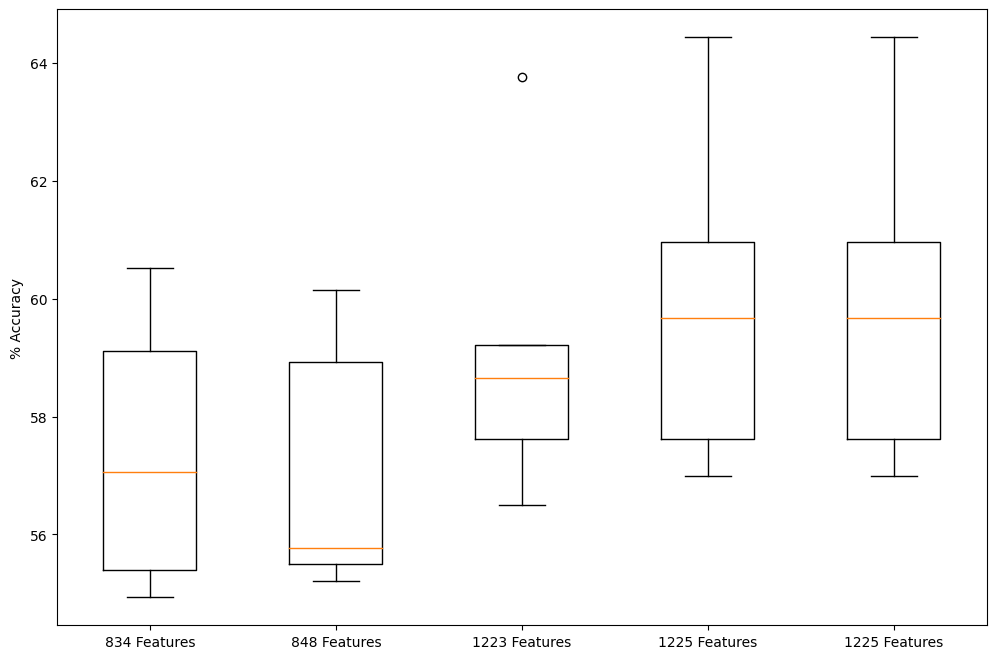

In [ ]:
fig, axes = plt.subplots(figsize=(int(len(method_n_descriptors)*2.5),8))

axes.set_ylabel("% Accuracy")
axes.boxplot(accuracy_result, labels = method_n_descriptors)

plt.show()

### Dense SIFT

Dense SIFT is a feature extraction method that computes dense local descriptors on a regular grid and can provide information about the texture of an image at different scales. Therefore, in this case we are the ones who define the position of the keypoints in the image and the descriptors are calculated at these positions.

The main parameters are the steps that control the distance between points on the grid, while the scale  determines the different scales to which these descriptors are applied, allowing information to be captured at different levels of detail in an image.

The next cell contains the functions to perform this task.

In [8]:
def extract_dense_sift_descriptors(image, step, scale):
    sift = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints = [cv2.KeyPoint(x, y, scale) for y in range(0, img.shape[0], step) for x in range(0, img.shape[1], step)]
    keypoints, descriptors = sift.compute(img, keypoints)
    return keypoints, descriptors

def compute_dense_sift_descriptors(images_filenames, step, scale):
    descriptor_image = []
    for image in images_filenames:
        img = cv2.imread(image)
        _, desc = extract_dense_sift_descriptors(img, step, scale)
        descriptor_image.append(desc)
    return descriptor_image

Below is an example of the number of keypoints that can be created in an image based on the selected step value. As we see, the smaller the step, the smaller the distance between keypoints and the greater number of them are computed. It should be taken into account that this fact will affect the performance of the system and the curse of dimensionality may occur.

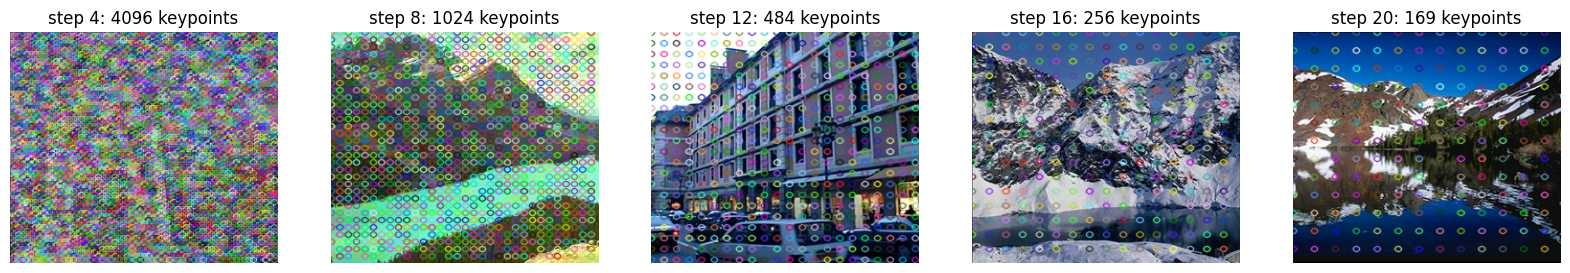

In [ ]:
images = np.random.choice(train_images_filenames, 5, replace = False)

fig, axes = plt.subplots(1, 5, figsize=(20, 3))

kp_list = []
for i, step in enumerate(range(4, 24, 4)):
    img = cv2.imread(images[i])
    kp, _ = extract_dense_sift_descriptors(img, step, 8)
    kp_list.append(kp)
    axes[i].imshow(cv2.cvtColor(cv2.drawKeypoints(cv2.imread(images[i]), kp_list[i], None), cv2.COLOR_BGR2RGB), aspect='auto')
    axes[i].set_title(f'step {step}: {len(kp_list[i])} keypoints')
    axes[i].axis('off')
plt.show()

To evaluate the performance of the algorithm, first an experiment is carried out setting the scale to a value of 8 and with different steps, from 16 to 50 in steps of 4. The rest of the parameters and configurations are set the same as in the previous cases.

It should be said that we start with steps of 16 since with lower values we have problems due to RAM memory overflow.

In [ ]:
n_clusters = 128
n_folds = 5
random_state = 42

kf = StratifiedKFold(n_splits=n_folds, random_state = random_state, shuffle=True)
accuracy_result = []

for step in range(16, 54, 4):
    descriptor_list = compute_dense_sift_descriptors(images_filenames, step, 8)

    accuracy_step = []
    for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
        #train and test data for this fold
        train_descriptor, test_descriptor = np.array(descriptor_list, dtype=object)[train_idx], np.array(descriptor_list, dtype=object)[test_idx]
        train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

        visual_words, visual_words_test = create_BoVW(train_descriptor, test_descriptor, n_clusters, random_state)

        knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knn.fit(visual_words, train_labels)

        accuracy_step.append(accuracy_score(test_labels, knn.predict(visual_words_test))*100)

    accuracy_result.append(accuracy_step)

We can see that the highest accuracy value is obtained with a step of 16 and that from here the system performance worsens.

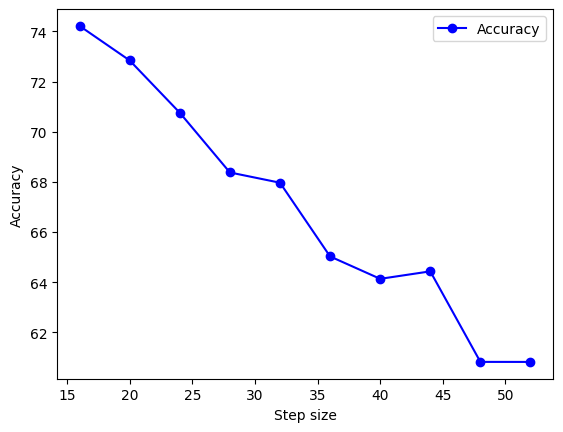

In [ ]:
plt.plot(range(16, 54, 4), np.mean(accuracy_result, axis=1), marker='o', linestyle='-', color='b', label='Accuracy')

plt.xlabel('Step size')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Now we vary the value of scala up to 12 to check the impact it has on the results.

In [ ]:
accuracy_result = []

for step in range(16, 54, 4):
    descriptor_list = compute_dense_sift_descriptors(images_filenames, step, 12)

    accuracy_step = []
    for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
        #train and test data for this fold
        train_descriptor, test_descriptor = np.array(descriptor_list, dtype=object)[train_idx], np.array(descriptor_list, dtype=object)[test_idx]
        train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

        visual_words, visual_words_test = create_BoVW(train_descriptor, test_descriptor, n_clusters, random_state)

        knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knn.fit(visual_words, train_labels)

        accuracy_step.append(accuracy_score(test_labels, knn.predict(visual_words_test))*100)

    accuracy_result.append(accuracy_step)

With this change, it is observed that the accuracy with a step of 20 grows unlike in the case with a scale value of 8. From here, the trend of the graph is similar, but in higher accuracy values compared to from the previous case. Therefore, increasing this value seems to have a positive effect on model performance.

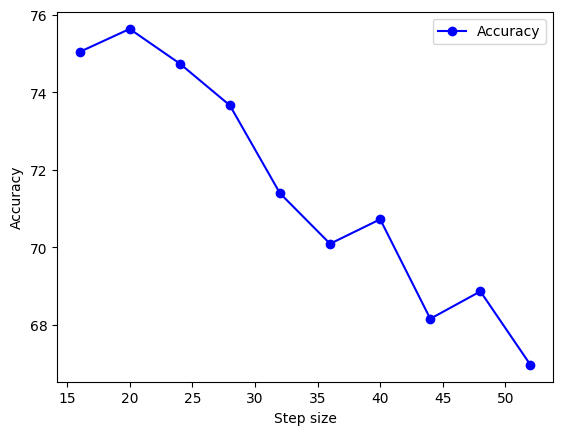

In [ ]:
plt.plot(range(16, 54, 4), np.mean(accuracy_result, axis=1), marker='o', linestyle='-', color='b', label='Accuracy')

plt.xlabel('Step size')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

A new experiment is carried out by raising the scala value to 16 to check if the trend of models with better results is maintained.

In [ ]:
accuracy_result = []

for step in range(16, 54, 4):
    descriptor_list = compute_dense_sift_descriptors(images_filenames, step, 16)

    accuracy_step = []
    for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
        #train and test data for this fold
        train_descriptor, test_descriptor = np.array(descriptor_list, dtype=object)[train_idx], np.array(descriptor_list, dtype=object)[test_idx]
        train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

        visual_words, visual_words_test = create_BoVW(train_descriptor, test_descriptor, n_clusters, random_state)

        knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knn.fit(visual_words, train_labels)

        accuracy_step.append(accuracy_score(test_labels, knn.predict(visual_words_test))*100)

    accuracy_result.append(accuracy_step)

In this case, the best accuracy value is obtained with a step of 16 and it decreases, just as it happened with a scale of 8, but with higher performance. It should be said that increasing the scale number also increases the computational complexity of the system. For this reason, and since the performance is similar, it was decided to use the scale value 12 for the rest of the analysis.
​

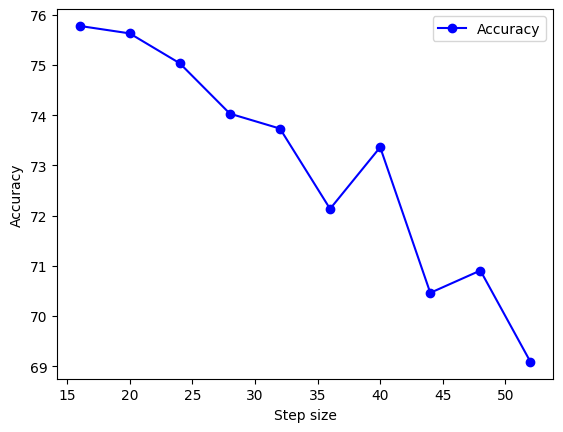

In [ ]:
plt.plot(range(16, 54, 4), np.mean(accuracy_result, axis=1), marker='o', linestyle='-', color='b', label='Accuracy')

plt.xlabel('Step size')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Now that the scale parameter value has been set to 12, we will seek to fine-tune the most appropriate step value. For this reason, steps from 18 to 24 are analyzed in steps of 1.

In [ ]:
accuracy_result = []

for step in range(18, 25, 1):
    descriptor_list = compute_dense_sift_descriptors(images_filenames, step, 12)

    accuracy_step = []
    for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
        #train and test data for this fold
        train_descriptor, test_descriptor = np.array(descriptor_list, dtype=object)[train_idx], np.array(descriptor_list, dtype=object)[test_idx]
        train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

        visual_words, visual_words_test = create_BoVW(train_descriptor, test_descriptor, n_clusters, random_state)

        knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knn.fit(visual_words, train_labels)

        accuracy_step.append(accuracy_score(test_labels, knn.predict(visual_words_test))*100)

    accuracy_result.append(accuracy_step)

If we look at the results, we see that with a step value of 22 the model performance exceeds 76% accuracy, which is the best score obtained so far. Therefore, this step value is fixed for the rest of the analysis.

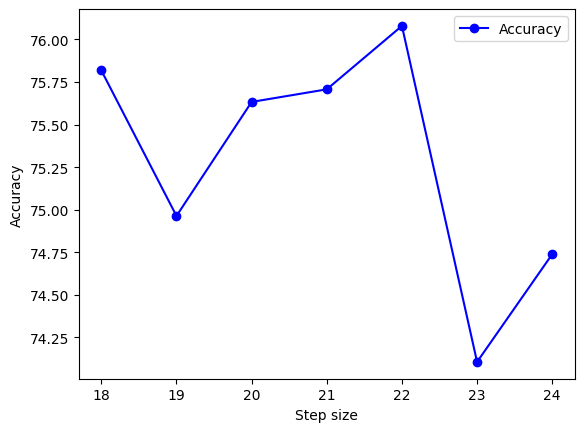

In [ ]:
plt.plot(range(18, 25, 1), np.mean(accuracy_result, axis=1), marker='o', linestyle='-', color='b', label='Accuracy')

plt.xlabel('Step size')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Finally, it is worth mentioning again that smaller step values and larger scales have not been tested due to the limitations and computational costs of RAM memory involved.

### Normalization / Standardization

Normalization is the process of scaling data to a specific range, such as [0, 1], while standardization involves transforming the data so that it has a mean of 0 and a standard deviation of 1.

To analyze the effect of these methods on the results, various experiments are carried out. In this sense, you can choose to apply normalization at different points of the execution. The options defined are the following:

* Option 0: Nothing is normalized/standardized.
* Option 1: The descriptions obtained by the local feature extraction algorithm are normalized/standardized.
* Option 2: The generated visual words are normalized/standardized.
* Option 3: Descriptors and visual words are normalized/standardized.



In [ ]:
n_clusters = 128
n_folds = 5
random_state = 42

kf = StratifiedKFold(n_splits=n_folds, random_state = random_state, shuffle=True)

accuracy_result = []

descriptor_list = compute_dense_sift_descriptors(images_filenames, 22, 12)

for option in range(4):
    accuracy_step = []
    for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
        #train and test data for this fold
        train_descriptor, test_descriptor = np.array(descriptor_list, dtype=object)[train_idx], np.array(descriptor_list, dtype=object)[test_idx]
        train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

        if option == 1 or option == 3:
            scaler = StandardScaler()
            train_descriptor = scaler.fit_transform(np.vstack(train_descriptor)).reshape(len(train_labels), -1, 128)
            test_descriptor = scaler.transform(np.vstack(test_descriptor)).reshape(len(test_labels), -1, 128)

        visual_words, visual_words_test = create_BoVW(train_descriptor, test_descriptor, n_clusters, random_state)
        if option == 2 or option == 3:
            scaler_vw = StandardScaler()
            visual_words = scaler_vw.fit_transform(np.vstack(visual_words)).reshape(len(train_labels), n_clusters)
            visual_words_test = scaler_vw.transform(np.vstack(visual_words_test)).reshape(len(test_labels), n_clusters)

        knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knn.fit(visual_words, train_labels)

        accuracy_step.append(accuracy_score(test_labels, knn.predict(visual_words_test))*100)

    accuracy_result.append(accuracy_step)

The reason for using fit_transform on the training set (train_descriptor and train_visual_words) and only transform on the test set (test_descriptor and test_visual_words) is because the normalization is learned from the statistics of the training set and applies to both the training and test sets.

As can be seen with option 3, if the data of both the descriptors and the visual words are standardized, the accuracy score can be slightly improved compared to that obtained without applying any process (option 0).

In [ ]:
accuracy_result = np.array(accuracy_result)
df = pd.DataFrame([np.mean(accuracy_result, axis=1)], index=['Accuracy'])
df

0          1          2          3
Accuracy  76.079278  76.153212  75.409856  76.413782

Next we repeat the process using the min-max normalization

In [ ]:
accuracy_result = []

for option in range(4):
    accuracy_step = []
    for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
        #train and test data for this fold
        train_descriptor, test_descriptor = np.array(descriptor_list, dtype=object)[train_idx], np.array(descriptor_list, dtype=object)[test_idx]
        train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

        if option == 1 or option == 3:
            scaler = MinMaxScaler()
            train_descriptor = scaler.fit_transform(np.vstack(train_descriptor)).reshape(len(train_labels), -1, 128)
            test_descriptor = scaler.transform(np.vstack(test_descriptor)).reshape(len(test_labels), -1, 128)

        visual_words, visual_words_test = create_BoVW(train_descriptor, test_descriptor, n_clusters, random_state)
        if option == 2 or option == 3:
            scaler_vw = MinMaxScaler()
            visual_words = scaler_vw.fit_transform(np.vstack(visual_words)).reshape(len(train_labels), n_clusters)
            visual_words_test = scaler_vw.transform(np.vstack(visual_words_test)).reshape(len(test_labels), n_clusters)

        knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knn.fit(visual_words, train_labels)

        accuracy_step.append(accuracy_score(test_labels, knn.predict(visual_words_test))*100)

    accuracy_result.append(accuracy_step)

In this case the results do not improve and even get worse, so this type of normalization is ruled out.

In [ ]:
accuracy_result = np.array(accuracy_result)
df = pd.DataFrame([np.mean(accuracy_result, axis=1)], index=['Accuracy'])
df

0          1          2          3
Accuracy  74.441445  74.478619  74.106664  73.586218

### KNN

In this section, experiments are carried out to obtain the best possible configuration of the parameters of the number of neighbors and distance metric of the KNN classifier as well as the cluster number of the clustering algorithm. In this case, a more extensive search process is carried out without setting any of the 3 mentioned parameters to avoid biases due to the strong relationship and dependence they have between them.

The process is carried out with the help of the Optuna library and some of the parameters mentioned above are set: use of the dense Sift algorithm with a number of steps of 22 and a scale of 12, cross-validation with 5 folds and the standardization of the data mentioned.

The defined search space is with respect to the number of clusters [64, 128, 256, 512], the Euclidean, cosine and Manhattan distance metrics and the number of neighbors between 3 and 19, always with an odd value.

In [9]:
def create_BoVW_opt(trial, train, test, random_state = None):
    n_clusters = trial.suggest_categorical('n_clusters', [64, 128, 256, 512])

    codebook = MiniBatchKMeans(n_clusters=n_clusters, verbose=False, batch_size=n_clusters * 20, compute_labels=False, reassignment_ratio=10**-4, random_state=random_state, n_init=10)
    codebook.fit(np.vstack(train))

    visual_words=np.zeros((len(train),n_clusters),dtype=np.float32)
    for i in range(len(train)):
        words=codebook.predict(train[i])
        visual_words[i,:]=np.bincount(words,minlength=n_clusters)

    visual_words_test=np.zeros((len(test),n_clusters),dtype=np.float32)
    for i in range(len(test)):
        words=codebook.predict(test[i])
        visual_words_test[i,:]=np.bincount(words,minlength=n_clusters)

    return visual_words, visual_words_test, n_clusters

def create_knn_opt(trial):

    distance_metric = trial.suggest_categorical('metric', ['euclidean', 'cosine', 'manhattan'])
    n_neighbors = trial.suggest_int('n_neighbors', 3, 19, step=2)

    return KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1,metric=distance_metric)

def objective(trial, descriptor_list, labels):
    n_folds = 5
    random_state = 42

    kf = StratifiedKFold(n_splits=n_folds, random_state = random_state, shuffle=True)

    accuracy_result = []
    for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
        #train and test data for this fold
        train_descriptor, test_descriptor = np.array(descriptor_list, dtype=object)[train_idx], np.array(descriptor_list, dtype=object)[test_idx]
        train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

        scaler = StandardScaler()
        train_descriptor = scaler.fit_transform(np.vstack(train_descriptor)).reshape(len(train_labels), -1, 128)
        test_descriptor = scaler.transform(np.vstack(test_descriptor)).reshape(len(test_labels), -1, 128)

        visual_words, visual_words_test, n_clusters = create_BoVW_opt(trial, train_descriptor, test_descriptor, random_state)

        scaler_vw = StandardScaler()
        visual_words = scaler_vw.fit_transform(np.vstack(visual_words)).reshape(len(train_labels), n_clusters)
        visual_words_test = scaler_vw.transform(np.vstack(visual_words_test)).reshape(len(test_labels), n_clusters)

        knn = create_knn_opt(trial)
        knn.fit(visual_words, train_labels)

        accuracy_result.append(accuracy_score(test_labels, knn.predict(visual_words_test))*100)

    return np.mean(accuracy_result)

Once the functions are defined, we create the experiment and the search for optimized parameters is automatically executed.


In [ ]:
descriptor_list = compute_dense_sift_descriptors(images_filenames, 22, 12)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, descriptor_list, labels), n_trials=30)

As a result, the best configuration is obtained with 512 clusters, the cosine metric and 11 neighbors with an accuracy score of 79.94%.

In [ ]:
print(f'Params: {study.best_params}, Accuracy: {study.best_value}')

Params: {'n_clusters': 512, 'metric': 'cosine', 'n_neighbors': 11}, Accuracy: 79.94738773164974


The library also allows different forms of visualization of the results of the experiments in relation to the parameters that need to be optimized, which allows increasing the understanding of what is happening.

In the following graph we can see that the metric that obtains the highest accuracy values is that of cosine with a difference compared to the other two. It also highlights that there are a greater number of experiments that have used this metric. It should be noted that this selection and search for optional parameters is carried out intelligently due to some characteristics of the library such as the probablistic model to estimate the relationship between the parameters and the objective variable or the Bayesian sampling in the search space.

Regarding the number of clusters, we see a large number of experiments with 256 clusters, but the one that obtains the best results is with 512. Finally, regarding the number of neighbors there is a greater dispersion, if the highest values are concentrated in around 9 and 15, with 11 being the highest.

In [ ]:
optuna.visualization.plot_slice(study, params=['n_clusters', 'metric', 'n_neighbors'])

The parallel coordinate plot is useful for visualizing and comparing the influence of multiple hyperparameters on the target metric, facilitating the identification of patterns, trends, and decision making in experiment optimization.

In this case, we significantly see how the cosino metric brings together the best results (in strong blue), 256 and 512 concentrate the options to select the number of clusters and disperse a little more with respect to the number of neighbors.

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

Finally, if we look at the influence of the hyperparameters with the target variable we can confirm the observations made previously, where the metric is the most important, followed by the number of clusters. In this sense, the number of neighbors has no influence on the result.

In [ ]:
optuna.visualization.plot_param_importances(study)

### SVM

The same strategy is followed as with the KNN algorithm to search for the optimal SVM parameters. Again, the most appropriate cluster number will be explored to define the size of the visual words prior to the classifier due to their dependence.

Regarding SVM's own parameters, the search focuses on the kernel (linear, histogram intersection or RBF) and the value of parameter C with possible values between 0.01 and 10.

In [10]:
def create_BoVW_opt(trial, train, test, random_state = None):
    n_clusters = trial.suggest_categorical('n_clusters', [64, 128, 256, 512])

    codebook = MiniBatchKMeans(n_clusters=n_clusters, verbose=False, batch_size=n_clusters * 20, compute_labels=False, reassignment_ratio=10**-4, random_state=random_state, n_init=10)
    codebook.fit(np.vstack(train))

    visual_words=np.zeros((len(train),n_clusters),dtype=np.float32)
    for i in range(len(train)):
        words=codebook.predict(train[i])
        visual_words[i,:]=np.bincount(words,minlength=n_clusters)

    visual_words_test=np.zeros((len(test),n_clusters),dtype=np.float32)
    for i in range(len(test)):
        words=codebook.predict(test[i])
        visual_words_test[i,:]=np.bincount(words,minlength=n_clusters)

    return visual_words, visual_words_test, n_clusters


def histogram_intersection_kernel(M, N):
    return np.minimum(M[:, np.newaxis, :], N[np.newaxis, :, :]).sum(axis=2)

def create_svm_opt(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'histogram', 'rbf'])
    C = trial.suggest_float('C', 0.01, 10)

    if kernel == 'histogram':
        return SVC(C = C, kernel = histogram_intersection_kernel)
    else:
        return SVC(C = C,  kernel = kernel)

def objective(trial, descriptor_list, labels):
    n_folds = 5
    random_state = 42

    kf = StratifiedKFold(n_splits=n_folds, random_state = random_state, shuffle=True)

    accuracy_result = []
    for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
        #train and test data for this fold
        train_descriptor, test_descriptor = np.array(descriptor_list, dtype=object)[train_idx], np.array(descriptor_list, dtype=object)[test_idx]
        train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

        scaler = StandardScaler()
        train_descriptor = scaler.fit_transform(np.vstack(train_descriptor)).reshape(len(train_labels), -1, 128)
        test_descriptor = scaler.transform(np.vstack(test_descriptor)).reshape(len(test_labels), -1, 128)

        visual_words, visual_words_test, n_clusters = create_BoVW_opt(trial, train_descriptor, test_descriptor, random_state)

        scaler_vw = StandardScaler()
        visual_words = scaler_vw.fit_transform(np.vstack(visual_words)).reshape(len(train_labels), n_clusters)
        visual_words_test = scaler_vw.transform(np.vstack(visual_words_test)).reshape(len(test_labels), n_clusters)

        svm = create_svm_opt(trial)
        svm.fit(visual_words, train_labels)

        accuracy_result.append(accuracy_score(test_labels, svm.predict(visual_words_test))*100)

    return np.mean(accuracy_result)

Once the functions are defined, we create the experiment and the search for optimized parameters is automatically executed.

In [ ]:
descriptor_list = compute_dense_sift_descriptors(images_filenames, 22, 12)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, descriptor_list, labels), n_trials=30)

As a result, the best configuration is obtained with 512 clusters, the RBF kernel and a value of 1.88 for parameter C with an accuracy score of 85.67%.


In [ ]:
print(f'Params: {study.best_params}, Accuracy: {study.best_value}')

Params: {'n_clusters': 512, 'kernel': 'rbf', 'C': 1.884885246078188}, Accuracy: 85.67665607498634


If we look at the graphs of the results obtained according to each parameter, we see that for parameter C the highest concentration of points with a highest score accuracy is around 2, with 1.88 being the best, but there is dispersion. Regarding the type of kernel, it is observed that the RBF kernel significantly outperforms the rest. Finally, a significantly relationship is also observed in which as the number of clusters increases, the accuracy value improves.

In [ ]:
optuna.visualization.plot_slice(study, params=['n_clusters', 'kernel', 'C'])

We can see how the vast majority of trials with a higher accuracy are located around the value 2 of C and converge in the RBF kernel. Regarding the number of clusters, it is more complicated to observe due to the small number of lines, although we can see that all those that reach the value 512 are dark while in the rest of the cases there are light lines, which indicates an lower accuracy value.

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

Finally, we can see how in this case the most important parameter for the objective function is the number of selected clusters followed by the kernel type. Parameter C has little influence compared to the other two for the performance of the model.

In [ ]:
optuna.visualization.plot_param_importances(study)

### Dimensionality reduction

Dimensionality reduction algorithms allow us to capture the most important characteristics of a data set by significantly reducing the number of dimensions. This section explores the use of PCA (Principal Component Analysis) and LDA (Linear Discriminant Analysis) as a mechanism to reduce the dimensionality of the data.

Optuna is again used to find the most appropriate parameters. In this case, it must be determined which of the two algorithms works best and the number of components in each case. Additionally, three possible values of parameter C of the SVM classifier are provided to finish analyzing whether its influence is as low as that observed previously.

Por lo que respecta al número de componentes, se xploran las opciones entre 2 y 7, ya que es el máximo posible en el algoritmo LDA (siempre debe ser uno menos que el máximo de clases)

In [11]:
def create_BoVW_final(train, test, n_clusters, random_state = None):

    codebook = MiniBatchKMeans(n_clusters=n_clusters, verbose=False, batch_size=n_clusters * 20, compute_labels=False, reassignment_ratio=10**-4, random_state=random_state, n_init=10)
    codebook.fit(np.vstack(train))

    visual_words=np.zeros((len(train),n_clusters),dtype=np.float32)
    for i in range(len(train)):
        words=codebook.predict(train[i])
        visual_words[i,:]=np.bincount(words,minlength=n_clusters)

    visual_words_test=np.zeros((len(test),n_clusters),dtype=np.float32)
    for i in range(len(test)):
        words=codebook.predict(test[i])
        visual_words_test[i,:]=np.bincount(words,minlength=n_clusters)

    return visual_words, visual_words_test

def create_dim_reduction(trial, visual_words, visual_words_test, train_labels):
    algorithm = trial.suggest_categorical("algorithm", ['PCA', 'LDA'])
    components = trial.suggest_categorical("n_components", range(2,8))

    if algorithm == 'PCA':
        pca = PCA(n_components=components)
        visual_words = pca.fit_transform(visual_words)
        visual_words_test = pca.transform(visual_words_test)
        return visual_words, visual_words_test

    if algorithm == 'LDA':
        lda = LinearDiscriminantAnalysis(n_components=components)
        visual_words = lda.fit_transform(visual_words, train_labels)
        visual_words_test = lda.transform(visual_words_test)
        return visual_words, visual_words_test

def create_svm_opt(trial):
  C = trial.suggest_categorical("C", [1.8, 1.9, 2])
  return SVC(C = C,  kernel = 'rbf')

def objective(trial, descriptor_list, labels):
    n_folds = 5
    random_state = 42
    n_clusters = 512

    kf = StratifiedKFold(n_splits=n_folds, random_state = random_state, shuffle=True)

    accuracy_result = []
    for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
        #train and test data for this fold
        train_descriptor, test_descriptor = np.array(descriptor_list, dtype=object)[train_idx], np.array(descriptor_list, dtype=object)[test_idx]
        train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

        scaler = StandardScaler()
        train_descriptor = scaler.fit_transform(np.vstack(train_descriptor)).reshape(len(train_labels), -1, 128)
        test_descriptor = scaler.transform(np.vstack(test_descriptor)).reshape(len(test_labels), -1, 128)

        visual_words, visual_words_test = create_BoVW_final(train_descriptor, test_descriptor, n_clusters, random_state)

        scaler_vw = StandardScaler()
        visual_words = scaler_vw.fit_transform(np.vstack(visual_words)).reshape(len(train_labels), n_clusters)
        visual_words_test = scaler_vw.transform(np.vstack(visual_words_test)).reshape(len(test_labels), n_clusters)

        visual_words, visual_words_test = create_dim_reduction(trial, visual_words, visual_words_test, train_labels)

        svm = create_svm_opt(trial)
        svm.fit(visual_words, train_labels)

        accuracy_result.append(accuracy_score(test_labels, svm.predict(visual_words_test))*100)

    return np.mean(accuracy_result)

Once the functions are defined, we create the experiment and the search for optimized parameters is automatically executed.


In [ ]:
descriptor_list = compute_dense_sift_descriptors(images_filenames, 22, 12)

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, descriptor_list, labels), n_trials=20)

As a result, the best configuration is obtained with the algoritm LDA, 7 components a value of 1.8 for parameter C with an accuracy score of 82.29%.


In [29]:
print(f'Params: {study.best_params}, Accuracy: {study.best_value}')

Params: {'algorithm': 'LDA', 'n_components': 7, 'C': 1.8}, Accuracy: 82.29147196666044


If we look at the parameter graphs, we see how for parameter 1.8 and 1.9 they work better than 2. As far as the algorithms are concerned, LDA achieves a better result and a clear relationship is observed between increasing the number of components and obtaining a better accuracy score.

In [31]:
optuna.visualization.plot_slice(study, params=['algorithm', 'n_components', 'C'])

In this case, the most prominent relationship between the parameters is observed with respect to the number of components, where the blue lines are concentrated in the highest component values while the white lines with a worse accuracy are related to a smaller number of components.

In [32]:
optuna.visualization.plot_parallel_coordinate(study)

Finally, regarding the importance of the parameters, it is observed that 97% of the influence is determined by the number of components selected as we had observed.

In [33]:
optuna.visualization.plot_param_importances(study)

Therefore, there is a clear relationship between the number of components and performance. However, while for the LDA algorithm the search space for the number of components has been as large as possible, for PCA it has been considerably limited to match it. Given the great importance of this parameter, this has introduced bias into the analysis. For this reason, additional experiments are carried out with the PCA algorithm to be able to more robustly measure its performance as a function of the number of components.

In this case, the parameter C is set to 1.9 and the search space for the number of components is increased to the maximum possible, which, in this case, is 512, equal to the dimensions of visual words.

In [68]:
n_clusters = 512
n_folds = 5
random_state = 42

kf = StratifiedKFold(n_splits=n_folds, random_state = random_state, shuffle=True)

descriptor_list = compute_dense_sift_descriptors(images_filenames, 22, 12)

accuracy_result = []

for components in range(8, 513, 126):

    accuracy_grid = []

    for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
        #train and test data for this fold
        train_descriptor, test_descriptor = np.array(descriptor_list, dtype=object)[train_idx], np.array(descriptor_list, dtype=object)[test_idx]
        train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

        scaler = StandardScaler()
        train_descriptor = scaler.fit_transform(np.vstack(train_descriptor)).reshape(len(train_labels), -1, 128)
        test_descriptor = scaler.transform(np.vstack(test_descriptor)).reshape(len(test_labels), -1, 128)

        visual_words, visual_words_test = create_BoVW_final(train_descriptor, test_descriptor, n_clusters, random_state)

        scaler_vw = StandardScaler()
        visual_words = scaler_vw.fit_transform(np.vstack(visual_words)).reshape(len(train_labels), n_clusters)
        visual_words_test = scaler_vw.transform(np.vstack(visual_words_test)).reshape(len(test_labels), n_clusters)

        pca = PCA(n_components=components)
        visual_words = pca.fit_transform(visual_words)
        visual_words_test = pca.transform(visual_words_test)

        svm = SVC(C = 1.9,  kernel = 'rbf')
        svm.fit(visual_words, train_labels)

        accuracy_grid.append(accuracy_score(test_labels, svm.predict(visual_words_test))*100)

    accuracy_result.append(accuracy_grid)


In [70]:
accuracy_result = np.array(accuracy_result)
df = pd.DataFrame([np.mean(accuracy_result, axis=1)], columns=range(8, 513, 126), index=['Accuracy'])
df

8          134        260        386        512
Accuracy  80.542668  85.305255  85.194008  84.784878  84.561138

If we analyze the new results, we see that the PCA algorithm obtains better results compared to LDA. In this case, the best result is obtained with a number of components of 134. If we analyze the graph, we observe an initial tendency to improve performance as the number of components increases until a limit is reached in which performance decreases. , which can be related to the curse of dimensionality.

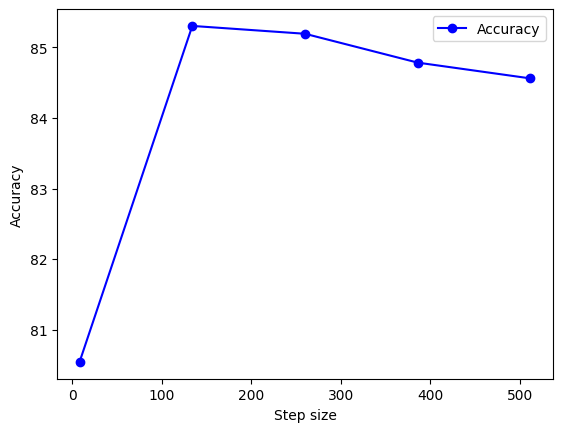

In [71]:
plt.plot(range(8, 513, 126), np.mean(accuracy_result, axis=1), marker='o', linestyle='-', color='b', label='Accuracy')

plt.xlabel('Step size')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Spatial Pyramids

The local descriptors used do not have the ability to capture the spatial information of the images, that is, the area in which a keypoint is located. To overcome this limitation, the spatial pyramid method implemented divides the image into NxN blocks and generates histograms for each of these blocks. In this case, the descriptors generated for the entire image are used and those found in the given block are taken into account to calculate its histogram.

In [12]:
def compute_dense_sift_descriptors_kp(images_filenames, step, scale):
    kp_image = []
    descriptor_image = []
    for image in images_filenames:
        img = cv2.imread(image)
        kp, desc = extract_dense_sift_descriptors(img, step, scale)
        descriptor_image.append(desc)
        kp_image.append(kp)
    return kp_image, descriptor_image

Below is an example of how this method works with example images.

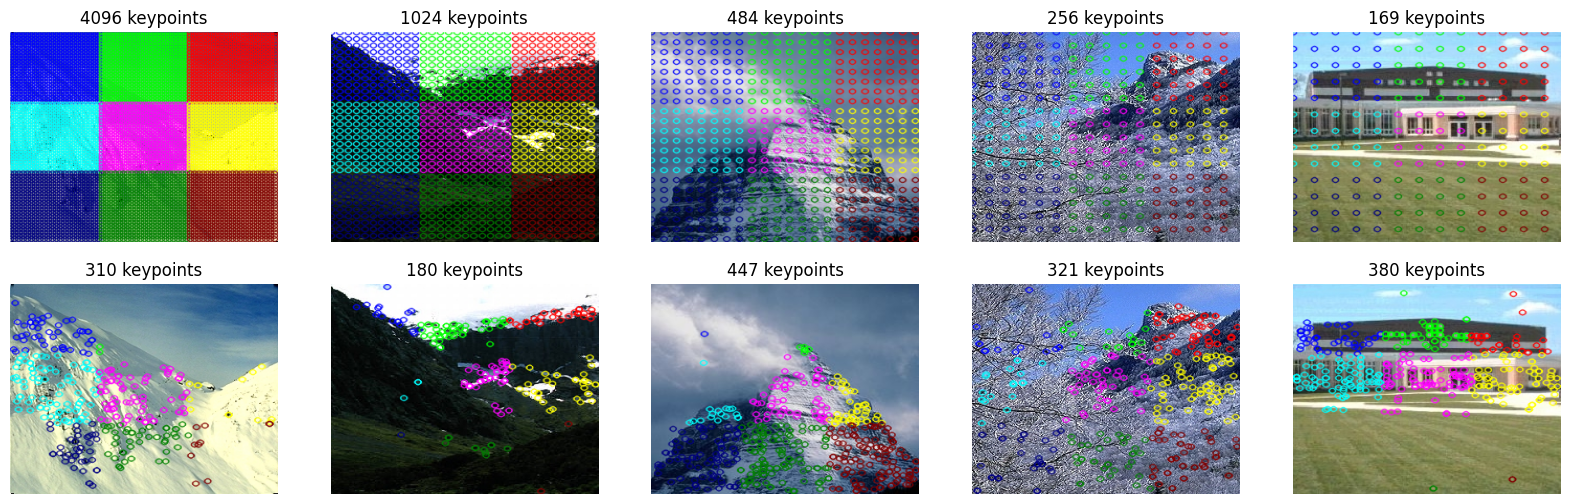

In [38]:
images = np.random.choice(train_images_filenames, 5, replace = False)

sift = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)

fig, axes = plt.subplots(2, 5, figsize=(20, 6))

grid = 3

subregion_height = 256 // grid
subregion_width = 256 // grid

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255), (128, 0, 0), (0, 128, 0), (0, 0, 128)]

for i, step in enumerate(range(4, 24, 4)):
    img = cv2.imread(images[i])

    kps_dense, _ = extract_dense_sift_descriptors(img, step, 8)
    kps, _ = extract_descriptors(img, sift)

    keypoints_grid = []
    for image_kp in [kps]:
        subregion_keypoints = [[] for _ in range(grid * grid)]
        for kp  in image_kp:
            col = int(kp.pt[0] // subregion_width)
            row = int(kp.pt[1] // subregion_height)
            subregion_keypoints[row * grid + col].append(kp)
        keypoints_grid.append(subregion_keypoints)

    keypoints_dense_grid = []
    for image_kp in [kps_dense]:
        subregion_keypoints = [[] for _ in range(grid * grid)]
        for kp  in image_kp:
            col = int(kp.pt[0] // subregion_width)
            row = int(kp.pt[1] // subregion_height)
            subregion_keypoints[row * grid + col].append(kp)
        keypoints_dense_grid.append(subregion_keypoints)

    img_dense = img.copy()
    img_sift = img.copy()
    for j, keypoints_in_subregion in enumerate(keypoints_grid[0]):
        color = colors[j % len(colors)]
        img_sift = cv2.drawKeypoints(img_sift, keypoints_in_subregion, None, color)

    for j, keypoints_in_subregion in enumerate(keypoints_dense_grid[0]):
        color = colors[j % len(colors)]
        img_dense = cv2.drawKeypoints(img_dense, keypoints_in_subregion, None, color)

    axes[0][i].imshow(cv2.cvtColor(img_dense, cv2.COLOR_BGR2RGB), aspect='auto')
    axes[0][i].set_title(f'{len(kps_dense)} keypoints')
    axes[0][i].axis('off')

    axes[1][i].imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB), aspect='auto')
    axes[1][i].set_title(f'{len(kps)} keypoints')
    axes[1][i].axis('off')
plt.show()

In the previous images, a grid of 3x3 blocks has been generated and the descriptors have been calculated using SIFT and dense SIFT. For each of these blocks, its own hisogram will be computed using its descriptors. As an example, the images have represented each keypoint of each block with a different color so that it can illustrate the idea of the implemented algorithm.

The following code is the one that computes these histograms based on the number of blocks indicated. The following code is the one that computes these histograms based on the number of blocks indicated. It is done at the time of creating the visual words where the hisogram of each block is calculated and all the histograms of the blocks of an image are concatenated. It should be noted that in return the computational complexity of using this method increases.
​

In [13]:
def create_svm_final():
    return SVC(C = 1.88,  kernel = 'rbf')

def create_BoVW_pyramid(train_desc, test_desc, train_kp, test_kp, n_clusters, grid, random_state = None):

    codebook = MiniBatchKMeans(n_clusters=n_clusters, verbose=False, batch_size=n_clusters * 20, compute_labels=False, reassignment_ratio=10**-4, random_state=random_state, n_init=10)
    codebook.fit(np.vstack(train_desc))

    subregion_height = 256 // grid
    subregion_width = 256 // grid

    train_descriptors_grid = []
    for image_kp, image_desc in zip(train_kp, train_desc):
        subregion_descriptors = [[] for _ in range(grid * grid)]
        for kp, desc in zip(image_kp, image_desc):
            col = int(kp.pt[0] // subregion_width)
            row = int(kp.pt[1] // subregion_height)
            subregion_descriptors[row * grid + col].append(desc)
        train_descriptors_grid.append(subregion_descriptors)

    visual_words=np.zeros((len(train_desc),n_clusters*grid*grid),dtype=np.float32)
    for i in range(len(train_descriptors_grid)):
        concatened_histograms = []
        for j in range(grid*grid):
            words=codebook.predict(train_descriptors_grid[i][j])
            act_hist = np.bincount(words,minlength=n_clusters)
            concatened_histograms.append(act_hist)
        visual_words[i,:]=np.concatenate(concatened_histograms)

    test_descriptors_grid = []
    for image_kp, image_desc in zip(test_kp, test_desc):
        subregion_descriptors = [[] for _ in range(grid * grid)]
        for kp, desc in zip(image_kp, image_desc):
            col = int(kp.pt[0] // subregion_width)
            row = int(kp.pt[1] // subregion_height)
            subregion_descriptors[row * grid + col].append(desc)
        test_descriptors_grid.append(subregion_descriptors)

    visual_words_test=np.zeros((len(test_desc),n_clusters*grid*grid),dtype=np.float32)
    for i in range(len(test_descriptors_grid)):
        concatened_histograms = []
        for j in range(grid*grid):
            words=codebook.predict(test_descriptors_grid[i][j])
            act_hist = np.bincount(words,minlength=n_clusters)
            concatened_histograms.append(act_hist)
        visual_words_test[i,:]=np.concatenate(concatened_histograms)

    return visual_words, visual_words_test

We carried out a experiment with 2x2, 3x3 and 4x4 blocks to evaluate the performance of the method.

In [10]:
n_clusters = 512
n_folds = 5
random_state = 42

kf = StratifiedKFold(n_splits=n_folds, random_state = random_state, shuffle=True)

keypoints, descriptors = compute_dense_sift_descriptors_kp(images_filenames, 22, 12)

accuracy_result = []

for grid in range(2,5):

    accuracy_grid = []

    for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
        #train and test data for this fold
        train_descriptor, test_descriptor = np.array(descriptors, dtype=object)[train_idx], np.array(descriptors, dtype=object)[test_idx]
        train_keypoints, test_keypoints = np.array(keypoints, dtype=object)[train_idx], np.array(keypoints, dtype=object)[test_idx]
        train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

        scaler = StandardScaler()
        train_descriptor = scaler.fit_transform(np.vstack(train_descriptor)).reshape(len(train_labels), -1, 128)
        test_descriptor = scaler.transform(np.vstack(test_descriptor)).reshape(len(test_labels), -1, 128)

        visual_words, visual_words_test = create_BoVW_pyramid(train_descriptor, test_descriptor, train_keypoints, test_keypoints, n_clusters, grid, random_state)

        scaler_vw = StandardScaler()
        visual_words = scaler_vw.fit_transform(np.vstack(visual_words)).reshape(len(train_labels), n_clusters*grid*grid)
        visual_words_test = scaler_vw.transform(np.vstack(visual_words_test)).reshape(len(test_labels), n_clusters*grid*grid)

        svm = create_svm_final()
        svm.fit(visual_words, train_labels)

        accuracy_grid.append(accuracy_score(test_labels, svm.predict(visual_words_test))*100)

    accuracy_result.append(accuracy_grid)


In this case we observe that as we increase the number of image blocks the result worsens. As we have said, this technique considerably increases the complexity and number of dimensions, which is why we have the problem of the curse of dimensionality.

In [43]:
accuracy_result = np.array(accuracy_result)
df = pd.DataFrame([np.mean(accuracy_result, axis=1)], columns=range(2, 5), index=['Accuracy'])
df

2          3          4
Accuracy  80.916423  79.131482  76.935612

### Conclusion

As a result of the different analyzes some conclusions can be drawn. First of all, we have verified that the algorithm that works best for this type of problem is dense SIFT compared to the rest of the local feature extractors tested. Furthermore, it has been verified that ORB works very poorly for this problem given its characteristics.

Regarding the classifier, the SVM algorithm has proven to be more powerful than KNN. This also corresponds to the expected behavior at a theoretical level.

On the other hand, fine tuning work has been done on a large number of parameters. In some cases, parameters have been set to adjust the analysis of the behavior of one of them. In other cases a grid search has been performed. For this topic, optuna has been used and its powerful visualizations that allow us to extract reasoning from what happened.

Another important aspect has been to explore some limitations such as the curse of dimensionality that has occurred in cases where complexity is increased, such as when extracting a greater number of descriptors with the spatil pyramids method. We have also been able to observe computational limitations of the process since in some cases we have not been able to test all the parameters that we would have liked due to the lack of computational resources.

Finally, some of the techniques have proven to be effective while others have failed to improve results. However, with time and resources, a more in-depth analysis could have been carried out. For example, increasing the number of clusters or reducing the number of steps in the dense SIFT algorithm, which would predictably obtain better results according to what we have seen.

Lastly, we want to perform a final analysis based on the configuration that obtains the best performance using the dense SIFT algorithm with steps of 22 and scale of 12, cross validation with 5 folds, 512 cluster to create the visual words and the SVM classifier with RBF kernel and C value of 1.88. In addition, the data is standardized according to what was explained.

In [15]:
n_clusters = 512
n_folds = 5
step = 22
scale = 12

random_state = 42

kf = StratifiedKFold(n_splits=n_folds, random_state = random_state, shuffle=True)

descriptor_list = compute_dense_sift_descriptors(images_filenames, step, scale)

accuracy_result = []
confusion_matrices = np.zeros((8, 8))

for train_idx, test_idx in kf.split(range(len(images_filenames)), labels):
    #train and test data for this fold
    train_descriptor, test_descriptor = np.array(descriptor_list, dtype=object)[train_idx], np.array(descriptor_list, dtype=object)[test_idx]
    train_labels, test_labels = np.array(labels)[train_idx], np.array(labels)[test_idx]

    scaler = StandardScaler()
    train_descriptor = scaler.fit_transform(np.vstack(train_descriptor)).reshape(len(train_labels), -1, 128)
    test_descriptor = scaler.transform(np.vstack(test_descriptor)).reshape(len(test_labels), -1, 128)

    visual_words, visual_words_test = create_BoVW_final(train_descriptor, test_descriptor, n_clusters, random_state)

    scaler_vw = StandardScaler()
    visual_words = scaler_vw.fit_transform(np.vstack(visual_words)).reshape(len(train_labels), n_clusters)
    visual_words_test = scaler_vw.transform(np.vstack(visual_words_test)).reshape(len(test_labels), n_clusters)

    svm = create_svm_final()
    svm.fit(visual_words, train_labels)

    accuracy_result.append(accuracy_score(test_labels, svm.predict(visual_words_test))*100)
    confusion_matrices+= confusion_matrix(test_labels, svm.predict(visual_words_test))

Below is the confusion matrix from the average results of each fold.

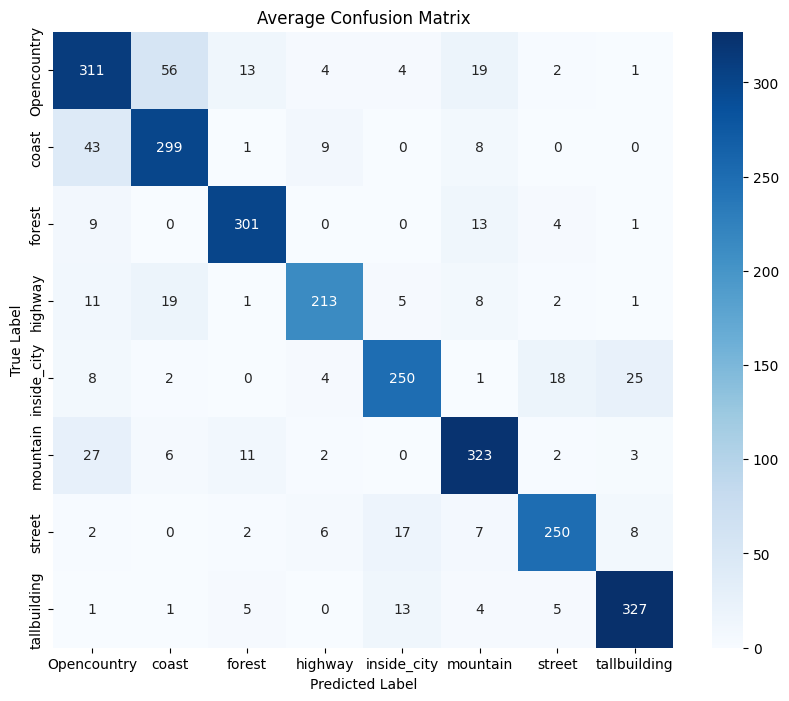

In [96]:
confusion_df = pd.DataFrame(confusion_matrices, index=np.unique(test_labels), columns=np.unique(test_labels))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')
plt.title('Average Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

This matrix shows the predictions of the classifier model for each class compared to the actual classes. The main diagonal represents the correct predictions for each class, while the off-diagonal entries indicate the incorrect classifications for each specific class.

By analyzing this matrix we can see the classes that are easier to classify compared to those where more errors appear. In this way, you can also see how images that are visually similar although they belong to different classes pose an added difficulty. For example, we see that there are a large number of images (56) that are *opencountry* and are incorrectly classified as *coast*. Analogously, up to a total of 43 *coast* images are classified as *opencountry*.

The next class that is confused with *opencountry* is *mountain*, since up to 27 images of this class appear classified as open country. On the other hand, the class that presents the least error is *tallbuilding*, so it may be an indicator that these images are significantly different from the rest of the groups. In any case, the class that *tallbuilding* makes the most mistakes with is *inside_city*, which is consistent with the visual appearance of these images. Additionally, *inside_city* images also tend to be confused with *street*.

### Class implementation

Functions to run previously

In [ ]:
def load_files(train_images_file, test_images_file, train_labels_filename, test_labels_filename):
    train_images_filenames = pickle.load(open(train_images_file,'rb'))
    test_images_filenames = pickle.load(open(test_images_file,'rb'))
    train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
    test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
    train_labels = pickle.load(open(train_labels_filename,'rb'))
    test_labels = pickle.load(open(test_labels_filename,'rb'))

    return train_images_filenames, test_images_filenames, train_labels, test_labels

train_images_filenames, test_images_filenames, train_labels, test_labels = load_files(
    'train_images_filenames.dat',
    'test_images_filenames.dat',
    'train_labels.dat',
    'test_labels.dat'
)

extractors = ['SIFT', 'AKAZE', 'ORB']

if not os.path.exists('testDescriptors') and not os.path.exists('trainDescriptors'):
    os.mkdir('testDescriptors')
    os.mkdir('trainDescriptors')
    for extractor in extractors:
        if extractor == 'SIFT':
            descriptor = cv2.SIFT_create()
        elif extractor == 'AKAZE':
            descriptor = cv2.AKAZE_create(threshold=0.0001)
        elif extractor == 'ORB':
            descriptor = cv2.ORB_create()

        train_descriptor = []
        for filename in tqdm(train_images_filenames):
            img = cv2.imread(filename, cv2.IMREAD_COLOR)
            imgGRAY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            kp, ds = descriptor.detectAndCompute(imgGRAY, None)
            train_descriptor.append(ds)


        with open('trainDescriptors/' + extractor + '.pkl', 'wb') as f:
            pickle.dump(train_descriptor, f)

        train_descriptor = []
        for filename in tqdm(test_images_filenames):
            img = cv2.imread(filename, cv2.IMREAD_COLOR)
            imgGRAY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            kp, ds = descriptor.detectAndCompute(imgGRAY, None)
            train_descriptor.append(ds)


        with open('testDescriptors/' + extractor + '.pkl', 'wb') as f:
            pickle.dump(train_descriptor, f)

#### Class


To wrap up everything we have done during this laboratory we create a class that enable us to perform better optimizations and to be more flexible. The class we create have this parameters:

```python
def __init__(self,
                 descriptor, descriptor_parameters, size_descriptor, # Descriptor types SIFT, ORB, AKAZE, DENSE_SIFT
                 codebook, codebook_parameters, # Codebook types K-MEANS, FISHER
                 classifier, classifier_parameters, # Classifier types KNN, SVC, LogisticRegression
                 scaler, # Scaler types None, MinMax, Stardarize, Normalize
                 dim_red, dim_red_parameters, # Dimension Reduction None, PCA
                 spatial_pyramid, # The spatial pyramid dim None 1...N
                 precomputed)
```

We split the inputs into 6 categories:
- **Descriptors**: We implement SIFT, ORB, AKAZE, DENSE_SIFT
- **CODEBOOK**: We implement K-MEANS and FISHER
- **CLASSIFIER**: We implement KNN, Support Vector Classifier and Logistic Regression
- **SCALER**: We implement the MinMax scaler, Standard scaler and Normalizer scaler
- **DIMENSION REDUCTION**: We implement PCA and LDA
- **SPATIAL PYRAMID**: Basically the square tiles you want to create

And the class have 3 methods:
- **fit(X, y)**:
    - X is the filename of the images in the form of a list of strings
    - y is the list of labels
    - Return: None

- **predict(X)**:
    - X is the filename of the images in the form of a list of strings
    - Return: a list of the predictions of the input

- **score(X, y)**:
    - X is the filename of the images in the form of a list of strings
    - y is the list of labels
    - Return: the score of the final model

In [ ]:
class BagOfVisualWords:
    def __init__(self,
                 descriptor, descriptor_parameters, size_descriptor, # Descriptor types SIFT, ORB, AKAZE, DENSE_SIFT
                 codebook, codebook_parameters, # Codebook types K-MEANS, FISHER
                 classifier, classifier_parameters, # Classifier types KNN, SVC, LogisticRegression
                 scaler, # Scaler types None, MinMax, Stardarize, Normalize
                 dim_red, dim_red_parameters, # Dimension Reduction None, PCA, LDA
                 spatial_pyramid, # The spatial pyramid dim None 1...N
                 precomputed
                 ):

        # Initialize descriptor
        self.size_descriptor = 0
        if descriptor == 'SIFT':
            self.descriptor = cv2.SIFT_create()

        elif descriptor == 'ORB':
            self.descriptor = cv2.ORB_create()

        elif descriptor == 'AKAZE':
            self.descriptor = cv2.AKAZE_create(threshold=0.0001)

        elif descriptor == 'DENSE_SIFT':
            self.size_descriptor = size_descriptor
            self.descriptor = cv2.SIFT_create(**descriptor_parameters)

        # Initialize codebook
        if codebook == 'K-MEANS':
            self.codebook = MiniBatchKMeans(**codebook_parameters)

        # Initialize the classifier
        if classifier == 'KNN':
            self.classifier = KNeighborsClassifier(**classifier_parameters)

        elif classifier == 'SVC':
            self.classifier = SVC(**classifier_parameters)

        elif classifier == 'LOGISTICREGRESSION':
            self.classifier = LogisticRegression(**classifier_parameters)

        # Initialize scaler
        self.scaler = None
        if scaler == 'MINMAX':
            self.scaler = MinMaxScaler()

        elif scaler == 'STANDARIZE':
            self.scaler = StandardScaler()

        elif scaler == 'NORMALIZE':
            self.scaler = Normalizer()

        # Initalize dimension reduction
        self.dim_red = None

        if dim_red == 'PCA':
            self.dim_red = PCA(**dim_red_parameters)

        # Initalize the spatial pyramid
        self.pyramid = spatial_pyramid

        # Initialize if get precomputed
        self.precomputed = precomputed
        self.precomputedType = descriptor

        # Initialize some useful variables
        self.codebook_used = codebook

    def get_k(self):
        if self.codebook_used == 'K-MEANS':
            return len(self.codebook.cluster_centers_)


    def fit(self, image_filenames, labels):

        # 1. Create the features
        train_descriptors = []
        train_labels = []
        level_descriptors = []

        if self.size_descriptor > 0:
            for image_filename, image_label in tqdm(zip(image_filenames, labels), total=len(image_filenames)):
                imageBGR = cv2.imread(image_filename, cv2.IMREAD_COLOR)
                imageGRAY = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2GRAY)

                dense_keypoints = [cv2.KeyPoint(x, y, self.size_descriptor) for y in range(0, imageGRAY.shape[0], self.size_descriptor)
                                                                            for x in range(0, imageGRAY.shape[1], self.size_descriptor)]
                _, ds = self.descriptor.compute(imageGRAY, dense_keypoints)
                train_descriptors.append(ds)
                train_labels.append(image_label)

                if self.pyramid > 1:
                    height, width = len(list(range(0, imageGRAY.shape[0], self.size_descriptor))), len(list(range(0, imageGRAY.shape[1], self.size_descriptor)))
                    ds_array = np.array(ds).reshape(height, width, -1)
                    features = ds_array.shape[2]

                    height_portion = math.ceil(height / self.pyramid)
                    width_portion = math.ceil(width / self.pyramid)

                    portions = []
                    for i in range(self.pyramid):
                        for j in range(self.pyramid):
                            actual = ds_array[i*height_portion:(i+1)*height_portion, j*width_portion:(j+1)*width_portion].reshape(-1, features)
                            portions.append(actual.tolist())

                    level_descriptors.append(portions.copy())

        else:
            if self.precomputed:
                with open('trainDescriptors/' + self.precomputedType + '.pkl', 'rb') as f:
                    train_descriptors = pickle.load(f)
                    train_labels = labels

            else:
                for image_filename, image_label in tqdm(zip(image_filenames, labels), total=len(image_filenames)):
                    imageBGR = cv2.imread(image_filename, cv2.IMREAD_COLOR)
                    imageGRAY = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2GRAY)

                    _, ds = self.descriptor.detectAndCompute(imageGRAY, None)
                    train_descriptors.append(ds)
                    train_labels.append(image_label)

        train_descriptors_column=np.vstack(train_descriptors)

        # 2. Train the codebook
        self.codebook.fit(train_descriptors_column)

        # 3. Compute the words on each image
        if self.pyramid > 1 and self.size_descriptor > 0:
            k = self.get_k()
            visual_words=np.zeros((len(train_descriptors), k * self.pyramid**2),dtype=np.float32)
            for i, image_level in enumerate(level_descriptors): # Cada imagen
                histogramas_concatenados = []
                for level in image_level: # Cada nivel de cada imagen
                    words=self.codebook.predict(np.array(level, dtype=np.float32))
                    act_hist = np.bincount(words,minlength=k)
                    histogramas_concatenados = histogramas_concatenados + act_hist.tolist()

                visual_words[i, :] = histogramas_concatenados.copy()

        else:
            k = self.get_k()
            visual_words=np.zeros((len(train_descriptors), k),dtype=np.float32)
            for i in range(len(train_descriptors)):
                words=self.codebook.predict(train_descriptors[i])
                visual_words[i,:]=np.bincount(words,minlength=k)


        # 4. Use the scaler
        if self.scaler is not None:
            self.scaler.fit(visual_words)
            visual_words = self.scaler.transform(visual_words)

        # 4. Use the dimension reduction
        if self.dim_red is not None:
            self.dim_red.fit(visual_words)
            visual_words = self.dim_red.transform(visual_words)

        # 5. Train the classifier
        self.classifier.fit(visual_words, train_labels)


    def predict(self, image_filenames):
        # 1. Create the features
        train_descriptors = []
        level_descriptors = []

        if self.size_descriptor > 0:
            for image_filename in tqdm(image_filenames):
                imageBGR = cv2.imread(image_filename, cv2.IMREAD_COLOR)
                imageGRAY = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2GRAY)

                dense_keypoints = [cv2.KeyPoint(x, y, self.size_descriptor) for y in range(0, imageGRAY.shape[0], self.size_descriptor)
                                                                            for x in range(0, imageGRAY.shape[1], self.size_descriptor)]
                _, ds = self.descriptor.compute(imageGRAY, dense_keypoints)
                train_descriptors.append(ds)

                if self.pyramid > 1:
                    height, width = len(list(range(0, imageGRAY.shape[0], self.size_descriptor))), len(list(range(0, imageGRAY.shape[1], self.size_descriptor)))
                    ds_array = np.array(ds).reshape(height, width, -1)
                    features = ds_array.shape[2]

                    height_portion = math.ceil(height / self.pyramid)
                    width_portion = math.ceil(width / self.pyramid)

                    portions = []
                    for i in range(self.pyramid):
                        for j in range(self.pyramid):
                            actual = ds_array[i*height_portion:(i+1)*height_portion, j*width_portion:(j+1)*width_portion].reshape(-1, features)
                            portions.append(actual.tolist())

                    level_descriptors.append(portions.copy())

        else:
            if self.precomputed:
                with open('testDescriptors/' + self.precomputedType + '.pkl', 'rb') as f:
                    train_descriptors = pickle.load(f)

            else:
                for image_filename in tqdm(image_filenames):
                    imageBGR = cv2.imread(image_filename, cv2.IMREAD_COLOR)
                    imageGRAY = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2GRAY)

                    _, ds = self.descriptor.detectAndCompute(imageGRAY, None)
                    train_descriptors.append(ds)

        # 2. Compute the words on each image
        if self.pyramid > 1 and self.size_descriptor > 0:
            k = self.get_k()
            visual_words=np.zeros((len(train_descriptors), k * self.pyramid**2),dtype=np.float32)
            for i, image_level in enumerate(level_descriptors): # Cada imagen
                histogramas_concatenados = []
                for level in image_level: # Cada nivel de cada imagen
                    words=self.codebook.predict(np.array(level, dtype=np.float32))
                    act_hist = np.bincount(words,minlength=k)
                    histogramas_concatenados = histogramas_concatenados + act_hist.tolist()

                visual_words[i, :] = histogramas_concatenados.copy()

        else:
            k = self.get_k()
            visual_words=np.zeros((len(train_descriptors), k),dtype=np.float32)
            for i in range(len(train_descriptors)):
                words=self.codebook.predict(train_descriptors[i])
                visual_words[i,:]=np.bincount(words,minlength=k)


        # 3. Use the scaler
        if self.scaler is not None:
            visual_words = self.scaler.transform(visual_words)

        # 4. Use the dimension reduction
        if self.dim_red is not None:
            visual_words = self.dim_red.transform(visual_words)

        # 5. Train the classifier
        return self.classifier.predict(visual_words)

    def score(self, image_filenames, labels):
        # 1. Create the features
        train_descriptors = []
        level_descriptors = []

        if self.size_descriptor > 0:
            for image_filename in tqdm(image_filenames):
                imageBGR = cv2.imread(image_filename, cv2.IMREAD_COLOR)
                imageGRAY = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2GRAY)

                dense_keypoints = [cv2.KeyPoint(x, y, self.size_descriptor) for y in range(0, imageGRAY.shape[0], self.size_descriptor)
                                                                            for x in range(0, imageGRAY.shape[1], self.size_descriptor)]
                _, ds = self.descriptor.compute(imageGRAY, dense_keypoints)
                train_descriptors.append(ds)

                if self.pyramid > 1:
                    height, width = len(list(range(0, imageGRAY.shape[0], self.size_descriptor))), len(list(range(0, imageGRAY.shape[1], self.size_descriptor)))
                    ds_array = np.array(ds).reshape(height, width, -1)
                    features = ds_array.shape[2]

                    height_portion = math.ceil(height / self.pyramid)
                    width_portion = math.ceil(width / self.pyramid)

                    portions = []
                    for i in range(self.pyramid):
                        for j in range(self.pyramid):
                            actual = ds_array[i*height_portion:(i+1)*height_portion, j*width_portion:(j+1)*width_portion].reshape(-1, features)
                            portions.append(actual.tolist())

                    level_descriptors.append(portions.copy())

        else:
            if self.precomputed:
                with open('testDescriptors/' + self.precomputedType + '.pkl', 'rb') as f:
                    train_descriptors = pickle.load(f)

            else:
                for image_filename in tqdm(image_filenames):
                    imageBGR = cv2.imread(image_filename, cv2.IMREAD_COLOR)
                    imageGRAY = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2GRAY)

                    _, ds = self.descriptor.detectAndCompute(imageGRAY, None)
                    train_descriptors.append(ds)

        # 2. Compute the words on each image
        if self.pyramid > 1 and self.size_descriptor > 0:
            k = self.get_k()
            visual_words=np.zeros((len(train_descriptors), k * self.pyramid**2),dtype=np.float32)
            for i, image_level in enumerate(level_descriptors): # Cada imagen
                histogramas_concatenados = []
                for level in image_level: # Cada nivel de cada imagen
                    words=self.codebook.predict(np.array(level, dtype=np.float32))
                    act_hist = np.bincount(words,minlength=k)
                    histogramas_concatenados = histogramas_concatenados + act_hist.tolist()

                visual_words[i, :] = histogramas_concatenados.copy()

        else:
            k = self.get_k()
            visual_words=np.zeros((len(train_descriptors), k),dtype=np.float32)
            for i in range(len(train_descriptors)):
                words=self.codebook.predict(train_descriptors[i])
                visual_words[i,:]=np.bincount(words,minlength=k)

        # 3. Use the scaler
        if self.scaler is not None:
            visual_words = self.scaler.transform(visual_words)

        # 4. Use the dimension reduction
        if self.dim_red is not None:
            visual_words = self.dim_red.transform(visual_words)

        # 5. Train the classifier
        return 100 * self.classifier.score(visual_words, labels)

#### Creating an instance of BagOfVisualWords

In [ ]:
BOVWSample = BagOfVisualWords(
                            descriptor = 'DENSE_SIFT', # Descriptor types SIFT, ORB, AKAZE, DENSE_SIFT
                            descriptor_parameters = {},
                            size_descriptor = 50,
                            codebook = 'K-MEANS', # Codebook types K-MEANS, FISHER
                            codebook_parameters = {
                                    'n_clusters': 128,
                                    'verbose': False,
                                    'batch_size': 128*20,
                                    'compute_labels': False,
                                    'reassignment_ratio': 10**-4,
                                    'random_state': 42
                                },
                            classifier = 'KNN', # Classifier types KNN, SVC, LOGISTICREGRESSION
                            classifier_parameters = {
                                    'n_neighbors': 5,
                                    'n_jobs': -1,
                                    'metric': 'euclidean'
                                },
                            scaler = None, # Scaler types None, MinMax, Stardarize, Normalize
                            dim_red = None,
                            dim_red_parameters = {}, # Dimension Reduction None, PCA
                            spatial_pyramid = 2, # The spatial pyramid dim 1...N
                            precomputed = True
                            )

BOVWSample.fit(train_images_filenames, train_labels)
BOVWSample.score(test_images_filenames, test_labels)

#### Optimizing an instance BagOfVisualWords


In [ ]:
def objective(trial):
    BOVWSample = BagOfVisualWords(
                            descriptor = 'DENSE_SIFT', # Descriptor types SIFT, ORB, AKAZE, DENSE_SIFT
                            descriptor_parameters = {},
                            size_descriptor = 50,
                            codebook = 'K-MEANS', # Codebook types K-MEANS, FISHER
                            codebook_parameters = {
                                    'n_clusters': trial.suggest_int('n_clusters', 128, 256),
                                    'verbose': False,
                                    'batch_size': trial.suggest_int('n_clusters', 128, 256) * 20,
                                    'compute_labels': False,
                                    'reassignment_ratio': 10**-4,
                                    'random_state': 42
                                },
                            classifier = 'KNN', # Classifier types KNN, SVC, LOGISTICREGRESSION
                            classifier_parameters = {
                                    'n_neighbors': trial.suggest_int('n_neighbors', 1, 20),
                                    'n_jobs': -1,
                                    'metric': trial.suggest_categorical('metric', ['euclidean', 'cosine', 'haversine'])
                                },
                            scaler = trial.suggest_categorical('scaler', ['MINMAX', 'STANDARIZE', 'NORMALIZE']), # Scaler types None, MinMax, Stardarize, Normalize
                            dim_red = None,
                            dim_red_parameters = {}, # Dimension Reduction None, PCA
                            spatial_pyramid = 2, # The spatial pyramid dim 1...N
                            precomputed = True
                            )

    BOVWSample.fit(train_images_filenames, train_labels)
    accuracy = BOVWSample.score(test_images_filenames, test_labels)
    return accuracy

study = optuna.create_study(direction="maximize")  # Create a new study.
study.optimize(objective, n_trials=1000)